In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score, silhouette_score
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN

# Data Preparation

In [2]:
# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')
products = pd.read_csv('Products.csv')

In [3]:
# Merge transactions with products to get category information
transactions = pd.merge(transactions, products[['ProductID', 'Category']], on='ProductID', how='left')
transactions.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,Category
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Electronics
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Electronics
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Electronics
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Electronics
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Electronics


In [4]:
# Aggregate transaction data by customer and category
category_aggregates = transactions.pivot_table(index='CustomerID', columns='Category', values='Quantity', aggfunc='sum', fill_value=0).reset_index()
category_aggregates.head()

Category,CustomerID,Books,Clothing,Electronics,Home Decor
0,C0001,2,0,7,3
1,C0002,0,4,0,6
2,C0003,0,4,4,6
3,C0004,8,0,6,9
4,C0005,0,0,4,3


In [5]:
# Find the most purchased category for each customer
category_aggregates['MostPurchasedCategory'] = category_aggregates.iloc[:, 1:].idxmax(axis=1)
category_aggregates.head()

Category,CustomerID,Books,Clothing,Electronics,Home Decor,MostPurchasedCategory
0,C0001,2,0,7,3,Electronics
1,C0002,0,4,0,6,Home Decor
2,C0003,0,4,4,6,Home Decor
3,C0004,8,0,6,9,Home Decor
4,C0005,0,0,4,3,Electronics


In [6]:
# Aggregate total transaction data
customer_transactions = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum'
}).reset_index()

In [7]:
# Merge with customer data
customer_data = pd.merge(customers, customer_transactions, on='CustomerID', how='left').fillna(0)
customer_data = pd.merge(customer_data, category_aggregates[['CustomerID', 'MostPurchasedCategory']], on='CustomerID', how='left')
customer_data.head()

,CustomerID,CustomerName,Region,SignupDate,TotalValue,Quantity,MostPurchasedCategory
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,12.0,Electronics
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,10.0,Home Decor
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,14.0,Home Decor
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,23.0,Home Decor
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,7.0,Electronics


# Feature Engineering

In [8]:
# Convert categorical data to numerical
customer_data['Region'] = customer_data['Region'].astype('category').cat.codes
customer_data['MostPurchasedCategory'] = customer_data['MostPurchasedCategory'].astype('category').cat.codes
customer_data.head()

,CustomerID,CustomerName,Region,SignupDate,TotalValue,Quantity,MostPurchasedCategory
0,C0001,Lawrence Carroll,3,2022-07-10,3354.52,12.0,2
1,C0002,Elizabeth Lutz,0,2022-02-13,1862.74,10.0,3
2,C0003,Michael Rivera,3,2024-03-07,2725.38,14.0,3
3,C0004,Kathleen Rodriguez,3,2022-10-09,5354.88,23.0,3
4,C0005,Laura Weber,0,2022-08-15,2034.24,7.0,2


In [9]:
# Select features
features = customer_data[['Region', 'TotalValue', 'Quantity']]
#features = customer_data[['Region', 'TotalValue', 'Quantity', 'MostPurchasedCategory']]
# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Determine Optimal Clusters

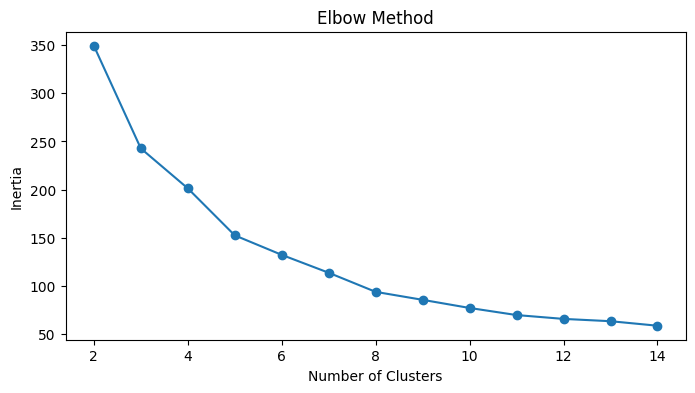

In [10]:
# Elbow method
inertia = []
for n in range(2, 15):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 4))
plt.plot(range(2, 15), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.savefig('elbow plot.png', bbox_inches='tight') 
plt.show()

# Using K means Clustering

In [11]:
# Choose the optimal number of clusters using elbow curve
optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(features_scaled)

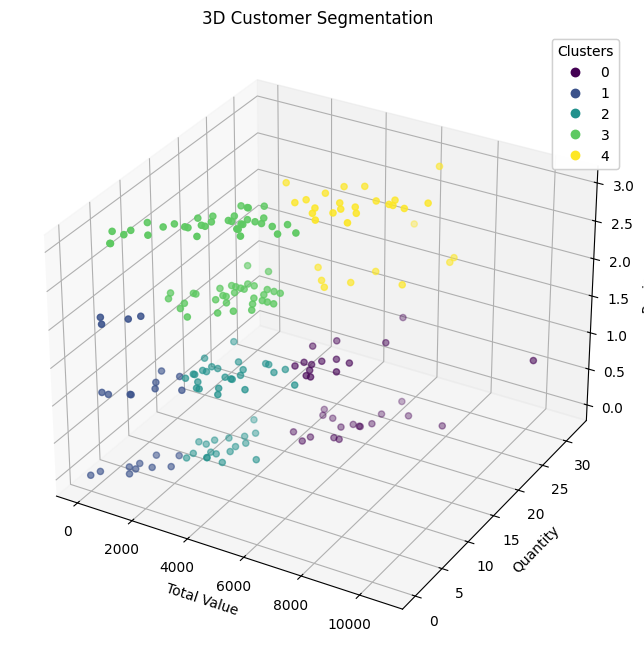

In [12]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the data
scatter = ax.scatter(
    customer_data['TotalValue'], 
    customer_data['Quantity'], 
    customer_data['Region'], 
    c=customer_data['Cluster'], 
    cmap='viridis'
)

# Set labels
ax.set_title('3D Customer Segmentation')
ax.set_xlabel('Total Value')
ax.set_ylabel('Quantity')
ax.set_zlabel('Region')

# Add legend
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)
plt.savefig('k-means.png', bbox_inches='tight') 
plt.show()

In [13]:
# Calculate DB Index
db_index = davies_bouldin_score(features_scaled, customer_data['Cluster'])

# Calculate Silhouette Score
silhouette_avg = silhouette_score(features_scaled, customer_data['Cluster'])

print(f'Davies-Bouldin Index: {db_index}')
print(f'Silhouette Score: {silhouette_avg}')

Davies-Bouldin Index: 0.9155126470969606
Silhouette Score: 0.3639440139800311


# Using DBSCAN

In [14]:
# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=8)
customer_data['Cluster'] = dbscan.fit_predict(features_scaled)

# Filter out noise points for evaluation
filtered_data = customer_data[customer_data['Cluster'] != -1]

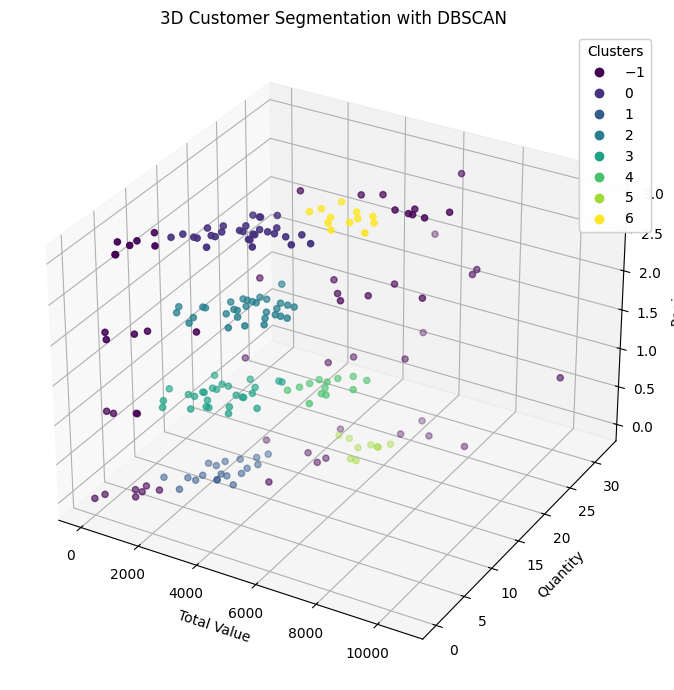

In [15]:
# 3D Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    customer_data['TotalValue'], 
    customer_data['Quantity'], 
    customer_data['Region'], 
    c=customer_data['Cluster'], 
    cmap='viridis'
)
ax.set_title('3D Customer Segmentation with DBSCAN')
ax.set_xlabel('Total Value')
ax.set_ylabel('Quantity')
ax.set_zlabel('Region')

# Adjust layout
plt.tight_layout()

legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)
plt.savefig('DBSCAN.png', bbox_inches='tight') 
plt.show()

In [16]:
# Calculate clustering metrics
if len(filtered_data) > 0:
    db_index = davies_bouldin_score(features_scaled[filtered_data.index], filtered_data['Cluster'])
    silhouette_avg = silhouette_score(features_scaled[filtered_data.index], filtered_data['Cluster'])
    print(f'Davies-Bouldin Index: {db_index}')
    print(f'Silhouette Score: {silhouette_avg}')
else:
    print("No clusters found.")

Davies-Bouldin Index: 0.8754078590495091
Silhouette Score: 0.4230767547916789
